In [ ]:
# default_exp customclientdata
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# CustomClientData

> Create custom TFF ClientData from Pandas Dataframe

***input***: none / raw data

***output***: function for creating custom tff ClientData

***description:***

In this notebook we generate customer path data, and transform it into tensorflow federated [ClientData](https://www.tensorflow.org/federated/tutorials/working_with_client_data) format.
You can edit the code to load and clean and transform your own client path data.

## Import relevant modules

Uncomment the following cell to run with the newest version of tff

In [ ]:
# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
#!pip uninstall --yes tensorboard tb-nightly

#!pip install --quiet --upgrade tensorflow-federated-nightly
#!pip install --quiet --upgrade nest-asyncio
#!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

In [ ]:
# export
import nest_asyncio

nest_asyncio.apply()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

2021-12-23 11:40:05.852008: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
from pyarrow import feather
from scipy.special import softmax

## Define notebook parameters

In [ ]:
# This cell is tagged with 'parameters' for papermill use
seed = 0

SHUFFLE_BUFFER = 100
NUM_EPOCHS = 1
BATCH_SIZE = 32

n_customers = 10000  # number of customers (paths, assuming only one path per customer)
max_path_length = 100  # limit simulation length

Define any immediate derivative operations from the parameters:

In [ ]:
# set seed
np.random.seed(seed)
tf.random.set_seed(seed)

## (or alternatively load your own data and turn it into an applicable format)

Try for example: https://cseweb.ucsd.edu/~jmcauley/datasets.html

or https://archive.ics.uci.edu/ml/datasets/Entree+Chicago+Recommendation+Data

In [ ]:
from pathlib import Path
import requests, zipfile, io

p = Path().cwd() / "data" / "raw_data"
if not (p / "customer-journey-unil-ch-datasets").exists():  # check if already loaded
    r = requests.get(
        "http://customer-journey.me/wp-content/uploads/2018/02/customer-journey-unil-ch-datasets.zip"
    )
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(p)

In [ ]:
filepaths = (
    p
    / "customer-journey-unil-ch-datasets"
    / "csv"
    / "configuration6"
    / "excluding-solution"
).glob("*.csv")


def read_csv_list_to_df(filepaths):
    max_trace_id = 0
    df_list = []
    for f in filepaths:
        df = pd.read_csv(f)
        df.trace_id += max_trace_id  # user id count begins from 0 at each file
        max_trace_id = df.trace_id.max()
        df_list.append(df)

    return pd.concat(df_list)


df = read_csv_list_to_df(filepaths)
df

,trace_id,activities,owner,employed,age,income
0,0,activity_09,no,yes,20-39yo,high
1,0,activity_04,no,yes,20-39yo,high
2,0,activity_02,no,yes,20-39yo,high
3,1,activity_09,no,yes,60-79yo,high
4,1,activity_04,no,yes,60-79yo,high
...,...,...,...,...,...,...
4298,4994,activity_07,yes,no,40-59yo,middle
4299,4994,activity_08,yes,no,40-59yo,middle
4300,4994,activity_09,yes,no,40-59yo,middle
4301,4995,activity_10,yes,yes,60-79yo,middle


In [ ]:
df.nunique()

trace_id      4996
activities      15
owner            2
employed         2
age              5
income           3
dtype: int64

In [ ]:
df.activities.unique()

array(['activity_09', 'activity_04', 'activity_02', 'activity_10',
       'activity_06', 'activity_03', 'activity_07', 'activity_08',
       'activity_01', 'activity_05', 'noise_2', 'noise_0', 'noise_4',
       'noise_3', 'noise_1'], dtype=object)

In [ ]:
df.age.unique()

array(['20-39yo', '60-79yo', '0-19yo', '40-59yo', '80yo+'], dtype=object)

In [ ]:
df.income.unique()

array(['high', 'middle', 'low'], dtype=object)

In [ ]:
df.trace_id = df.trace_id.astype("int")
df.activities = df.activities.astype("category")
df.owner = df.owner.map(lambda x: 1 if "yes" else 0).astype("uint8")
df.employed = df.employed.map(lambda x: 1 if "yes" else 0).astype("uint8")
df.age = df.age.map(
    {"0-19yo": 0, "20-39yo": 1, "40-59yo": 2, "60-79yo": 3, "80yo+": 4}
).astype("uint8")
df.income = df.income.map({"low": 0, "middle": 1, "high": 2}).astype("uint8")

In [ ]:
df.reset_index(inplace=True)
df.rename({"index": "action_index"}, axis=1, inplace=True)
df

,action_index,trace_id,activities,owner,employed,age,income
0,0,0,activity_09,1,1,1,2
1,1,0,activity_04,1,1,1,2
2,2,0,activity_02,1,1,1,2
3,3,1,activity_09,1,1,3,2
4,4,1,activity_04,1,1,3,2
...,...,...,...,...,...,...,...
21516,4298,4994,activity_07,1,1,2,1
21517,4299,4994,activity_08,1,1,2,1
21518,4300,4994,activity_09,1,1,2,1
21519,4301,4995,activity_10,1,1,3,1


In [ ]:
#
# we need extra category for denoting that client activity has stopped
activity_ended = f"activity_{df.activities.nunique()+1:d}"
df.activities = df.activities.cat.add_categories([activity_ended])

- order of events for customer

- next and previous event

In [ ]:
df.columns

Index(['action_index', 'trace_id', 'activities', 'owner', 'employed', 'age',
       'income'],
      dtype='object')

In [ ]:
prev_next_df = pd.DataFrame(
    columns={
        "client_id": int,
        "action_index": "uint8",
        "prev_activity": "category",
        "owner": "uint8",
        "employed": "uint8",
        "age": "uint8",
        "income": "uint8",
        "next_activity": "category",
    }
)

for client_id, client_data in df.groupby("trace_id"):
    client_data.action_index -= client_data.action_index.min()
    client_data.action_index = client_data.action_index.astype(int)
    # rename columns
    buf_df = client_data.rename(
        {"trace_id": "client_id", "activities": "prev_activity"}, axis=1
    )

    # add new column for next activity
    buf_df["next_activity"] = client_data.activities.shift(
        periods=-1, fill_value=activity_ended
    ).astype("category")
    # add buffer to prev_next_df
    prev_next_df = pd.concat((prev_next_df, buf_df), axis=0, ignore_index=True)

In [ ]:
prev_next_df

,client_id,action_index,prev_activity,owner,employed,age,income,next_activity
0,0,0,activity_09,1,1,1,2,activity_04
1,0,1,activity_04,1,1,1,2,activity_02
2,0,2,activity_02,1,1,1,2,activity_16
3,1,0,activity_09,1,1,3,2,activity_04
4,1,1,activity_04,1,1,3,2,activity_02
...,...,...,...,...,...,...,...,...
21516,4994,2,activity_07,1,1,2,1,activity_08
21517,4994,3,activity_08,1,1,2,1,activity_09
21518,4994,4,activity_09,1,1,2,1,activity_16
21519,4995,0,activity_10,1,1,3,1,activity_06


In [ ]:
# drop outliers
grouped_by_action_count = prev_next_df.groupby("client_id").max()[["action_index"]]
clients_to_be_dropped = (
    grouped_by_action_count[grouped_by_action_count.action_index > 10].dropna().index
)
# clients_to_be_dropped.to_numpy()
print(clients_to_be_dropped)
outliers = (
    prev_next_df.apply(
        lambda row: 1 if row.client_id in clients_to_be_dropped else np.nan, axis=1
    )
    .dropna()
    .index
)
print(outliers)
prev_next_df.drop(outliers, inplace=True)

Int64Index([999, 1998, 2997, 3996], dtype='int64', name='client_id')
Int64Index([ 4295,  4296,  4297,  4298,  4299,  4300,  4301,  4302,  8592,
             8593,  8594,  8595,  8596,  8597,  8598,  8599,  8600,  8601,
            12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 17213,
            17214, 17215, 17216, 17217, 17218, 17219],
           dtype='int64')


In [ ]:
prev_next_df.dropna(inplace=True)

In [ ]:
prev_next_df.nunique()

client_id        4992
action_index       11
prev_activity      15
owner               1
employed            1
age                 5
income              3
next_activity      16
dtype: int64

Drop uninformative columns that only contain one value

In [ ]:
prev_next_df.drop(["owner", "employed"], axis=1, inplace=True)

In [ ]:
prev_next_df["action_count"] = prev_next_df.action_index + 1

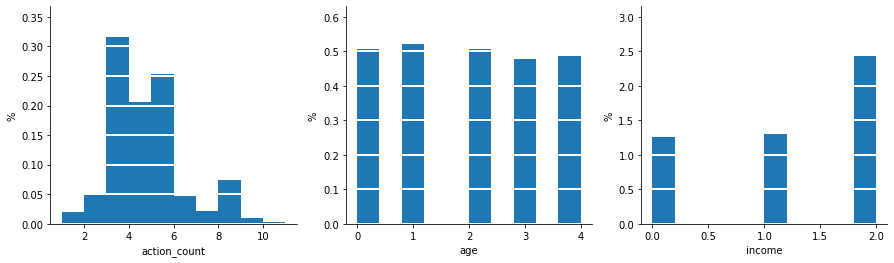

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, column in zip(axs, ["action_count", "age", "income"]):
    prev_next_df.groupby("client_id").max()[column].hist(ax=ax, density=True)
    ax.set_ylabel("%")
    ax.set_xlabel(column)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)
    [ax.axhline(tick, color="white", linewidth=2) for tick in ax.get_yticks()]

plt.savefig("results/client_histograms.png")

Ok, so most clients have from 3 to 5 actions (including end of journey). considering background information, all groups are well represented.

In [ ]:
#
# convert state feature into one hot
onehot = pd.get_dummies(prev_next_df.prev_activity, prefix="prev")
prev_next_df[onehot.columns] = onehot
prev_next_df.drop("prev_activity", axis=1, inplace=True)

# convert label categories into numerical format
# (this is because for the moment TFF does not support multi-output models)
prev_next_df[["next_activity"]] = prev_next_df[["next_activity"]].apply(
    lambda x: x.cat.codes
)
prev_next_df = prev_next_df.astype(int)

In [ ]:
prev_next_df.dtypes

client_id           int64
action_index        int64
age                 int64
income              int64
next_activity       int64
action_count        int64
prev_activity_01    int64
prev_activity_02    int64
prev_activity_03    int64
prev_activity_04    int64
prev_activity_05    int64
prev_activity_06    int64
prev_activity_07    int64
prev_activity_08    int64
prev_activity_09    int64
prev_activity_10    int64
prev_noise_0        int64
prev_noise_1        int64
prev_noise_2        int64
prev_noise_3        int64
prev_noise_4        int64
prev_activity_16    int64
dtype: object

In [ ]:
prev_next_df

,client_id,action_index,age,income,next_activity,action_count,prev_activity_01,prev_activity_02,prev_activity_03,prev_activity_04,...,prev_activity_07,prev_activity_08,prev_activity_09,prev_activity_10,prev_noise_0,prev_noise_1,prev_noise_2,prev_noise_3,prev_noise_4,prev_activity_16
0,0,0,1,2,3,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,1,2,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,2,15,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,3,2,3,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,3,2,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21516,4994,2,2,1,7,3,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
21517,4994,3,2,1,8,4,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
21518,4994,4,2,1,15,5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21519,4995,0,3,1,5,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
#
# We need to convert the data into untidy nested format for TFF
# so that x is a vector and y is a scalar
cxy_df = pd.DataFrame(columns=["client_id", "x", "y"])
cxy_df.client_id = prev_next_df.client_id
cxy_df.x = prev_next_df[
    prev_next_df.drop(["client_id", "next_activity"], axis=1).columns
].apply(lambda row: row.to_numpy(), axis=1)
cxy_df.y = prev_next_df.next_activity

cxy_df

,client_id,x,y
0,0,"[0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3
1,0,"[1, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1
2,0,"[2, 1, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15
3,1,"[0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3
4,1,"[1, 3, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...
21516,4994,"[2, 2, 1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",7
21517,4994,"[3, 2, 1, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",8
21518,4994,"[4, 2, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",15
21519,4995,"[0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5


## Save data for further use

In [ ]:
feather.write_feather(cxy_df, "data/preprocessed_data/data.f")

## Create function to convert df into tff ClientData

Following this discussion: https://stackoverflow.com/questions/58965488/how-to-create-federated-dataset-from-a-csv-file

In [ ]:
# export

import collections


def create_tff_client_data_from_df(
    df,
    client_id_col="client_id",
    sample_size=1.0,
    shuffle_buffer=100,
    batch_size=32,
    num_epochs=20,
    prefetch_buffer=100,
    shuffle_seed=42,
):
    """
    turn pd dataframe into tff client dataset
    """

    def batch_format_fn(element):
        """format data into OrderedDict where x denotes features and y labels for a client"""
        return collections.OrderedDict(
            x=element["x"],  # tf.reshape(element[xcol], [-1, xshape]),
            y=element["y"],  # tf.reshape(element[ycol], [-1, yshape]),
        )

    def create_tf_dataset_for_client_fn(client_id):
        """a function which takes a client_id and returns a tf.data.Dataset for that client"""
        client_data = df[df[client_id_col] == int(client_id)]
        # create tf dataset
        dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict("list"))
        # dataset = dataset.shuffle(shuffle_buffer).batch(num_batch).repeat(num_epochs)
        dataset = (
            dataset.repeat(num_epochs)
            .shuffle(shuffle_buffer, seed=shuffle_seed)
            .batch(batch_size)
            .map(batch_format_fn)
            .prefetch(prefetch_buffer)
        )
        return dataset

    # split client id into train and test clients
    client_ids = np.random.choice(
        df[client_id_col].unique(),
        size=int(sample_size * df[client_id_col].nunique()),
    ).tolist()  # proportion of clients to use

    # train data
    def create_mapping(client_ids):
        """
        create mapping of client ids
        """
        mapping = {}
        for client_id in client_ids:
            mapping[client_id] = str(client_id)
        return mapping

    # create CustomClientData
    # this is slight misuse of FilePerUserClientData but it works for now,
    # and there seems not to be another solution for the moment :D
    # (please suggest correction if there is a better solution)
    tff_data = tff.simulation.datasets.FilePerUserClientData(
        client_ids_to_files=create_mapping(client_ids),
        dataset_fn=create_tf_dataset_for_client_fn,
    )

    return tff_data

Test (well, at least it should not crash)

In [ ]:
tff_data = create_tff_client_data_from_df(cxy_df)

2021-12-23 11:41:39.523696: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-23 11:41:39.783200: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-23 11:41:39.783253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-nuutti-1a-m-mem): /proc/driver/nvidia/version does not exist
2021-12-23 11:41:39.785298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
tff_data.create_tf_dataset_for_client(tff_data.client_ids[0])

<PrefetchDataset shapes: OrderedDict([(x, (None, 20)), (y, (None,))]), types: OrderedDict([(x, tf.int64), (y, tf.int32)])>

In [ ]:
train_data, test_data = tff.simulation.datasets.ClientData.train_test_client_split(
    tff_data, 500
)

2021-12-23 11:41:39.966178: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-23 11:41:39.966611: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2095190000 Hz
